### Time series Forecasting using new notebook within venv.



In [1]:

# importing necessary libraries to deploy pyspark functions

from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

from pyspark.sql.functions import count # Funcion to get the "size" of the data.
from pyspark.sql.functions import when # When function.
from pyspark.sql.functions import col # Function column.
from pyspark.sql.functions import mean, min, max, stddev # Imports function for statistical features. 
from pyspark.sql import functions as F # Data processing framework.
from pyspark.sql.functions import size, split # Imports function size and split.
from pyspark.ml.feature import Tokenizer # Importing Tokenizer.
from pyspark.sql.functions import regexp_replace # Remove / Replace function.
from pyspark.sql.types import StructField, StructType # Importing features for Schema.
from pyspark.sql.types import IntegerType, StringType, TimestampType # Tools to create the schema.
from pyspark.sql.functions import udf # Imports function UDF (user defined functions).
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.functions import max as max_


from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StringIndexer, CountVectorizer, NGram, VectorAssembler, ChiSqSelector

from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from bs4 import BeautifulSoup  # For HTML parsing
from pyspark.sql.functions import lower

import numpy as np # for numerical operations.
import pandas as pd

import matplotlib.pyplot as plt # visualization
%matplotlib inline 


import warnings # Ignore warnings.
warnings.filterwarnings("ignore")




from sklearn.preprocessing import RobustScaler, PowerTransformer # Importing scalling tools.
from statsmodels.tsa.seasonal import seasonal_decompose # Imports seasonal decompose for time-series analysis.
from statsmodels.tsa.stattools import adfuller # Statistical approach for stationarity.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Auto-correlation plots for time-series analysis.
from statsmodels.tsa.ar_model import AutoReg # Imports Auto Regressive
from sklearn.metrics import mean_squared_error, mean_absolute_error # Imports metrics for evaluation.
from scipy import stats # Stats is for Shapiro test (normality).
from statsmodels.tsa.arima.model import ARIMA # ARIMA time series model.
from statsmodels.tsa.statespace.sarimax import SARIMAX# Imports SARIMA
import itertools # For hyper-parameter tunning.
import pmdarima as pm # Imports pmdarima to find optimal order values.
from pmdarima import auto_arima # Imports auto_arima for optimal parameters.


In [2]:
import subprocess

# Assuming the local file path
#local_file_path = "/home/hduser/Downloads/SentimentData.csv"
# Assuming the HDFS directory
#hdfs_directory = "hdfs:///user/hduser/CA2"

# Use subprocess to run the hdfs dfs -copyFromLocal command
#subprocess.run(["hdfs", "dfs", "-copyFromLocal", local_file_path, hdfs_directory])

### Importing file with complete date range and imputations of mean values 


In [3]:
from pyspark.sql import SparkSession

# Initialize a Spark session
spark = SparkSession.builder.appName("TimeSeries").getOrCreate()

# Specify the HDFS path to your CSV file
hdfs_path = "hdfs:///user/hduser/CA2/ImputData.csv"

# Read the CSV file into a PySpark DataFrame
pyspark_df = spark.read.csv(hdfs_path, header=True, inferSchema=True)

# Show the first few rows of the PySpark DataFrame
pyspark_df.show()

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = pyspark_df.toPandas()

# Now, you can use the Pandas DataFrame with statsmodels in your new notebook

+----------+---------+---------------+
| date_only|sentiment|sentiment_score|
+----------+---------+---------------+
|2009-04-07|      0.0|        -0.3818|
|2009-04-07|      0.0|        -0.7269|
|2009-04-07|      1.0|         0.4939|
|2009-04-07|      1.0|          -0.25|
|2009-04-07|      0.0|        -0.4939|
|2009-04-07|      0.0|            0.0|
|2009-04-07|      1.0|         0.4767|
|2009-04-07|      1.0|         0.8481|
|2009-04-07|      0.0|            0.0|
|2009-04-07|      0.0|            0.0|
|2009-04-07|      0.0|            0.0|
|2009-04-07|      0.0|            0.0|
|2009-04-07|      0.0|        -0.5994|
|2009-04-07|      0.0|        -0.1027|
|2009-04-07|      0.0|            0.0|
|2009-04-07|      1.0|         0.2732|
|2009-04-07|      0.0|        -0.9081|
|2009-04-07|      0.0|            0.0|
|2009-04-07|      1.0|         0.6369|
|2009-04-07|      1.0|         0.1779|
+----------+---------+---------------+
only showing top 20 rows



In [4]:
pandas_df.head()

,date_only,sentiment,sentiment_score
0,2009-04-07,0.0,-0.3818
1,2009-04-07,0.0,-0.7269
2,2009-04-07,1.0,0.4939
3,2009-04-07,1.0,-0.2500
4,2009-04-07,0.0,-0.4939


In [5]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600039 entries, 0 to 1600038
Data columns (total 3 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   date_only        1600039 non-null  object 
 1   sentiment        1600000 non-null  float64
 2   sentiment_score  1600039 non-null  float64
dtypes: float64(2), object(1)
memory usage: 36.6+ MB


### Data Preparation for Time Series Forecasting

To prepare the data for applying the models required for forecasting, its important to extract only the necessary features. In this case, date_only and sentiment_score will be used fro modeling. But first the date need to be reset as the index with the correct dtype.



In [11]:
# set date as datetime
#pandas_df['date_only'] = pd.to_datetime(pandas_df['date_only'])
#pandas_df.set_index('date_only', inplace=True)

# Create a new DataFrame with only 'sentiment_score'
new_df = pandas_df[['sentiment_score']].copy()
new_df.head()

,sentiment_score
date_only,
2009-04-07,-0.3818
2009-04-07,-0.7269
2009-04-07,0.4939
2009-04-07,-0.2500
2009-04-07,-0.4939


## Visualise the time series 


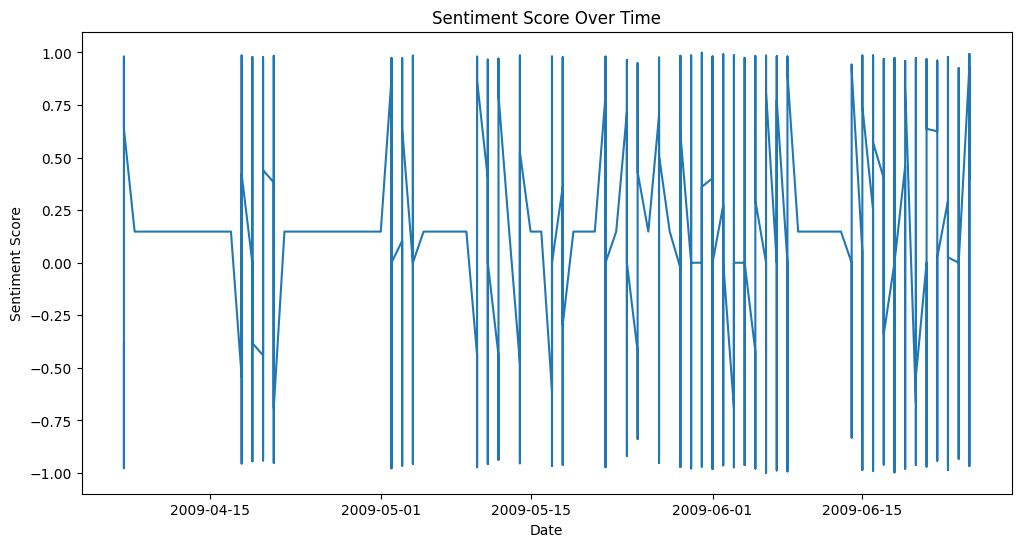

In [12]:
# create figure to see how the values change over time
plt.figure(figsize=(12, 6))
plt.plot(new_df['sentiment_score'])
plt.title('Sentiment Score Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.show()

## Seasonal decompose using additive model 


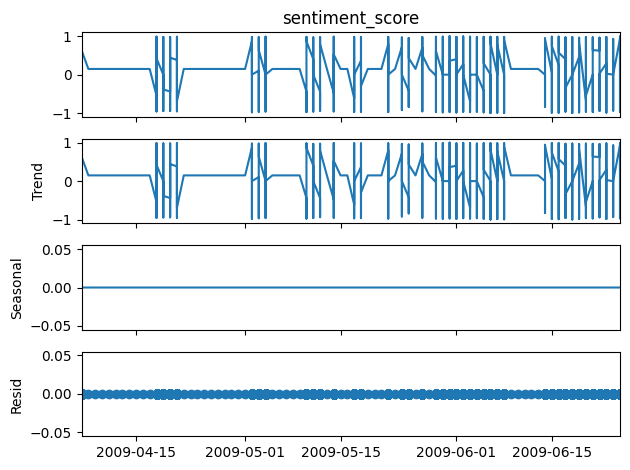

In [14]:
result = seasonal_decompose(new_df['sentiment_score'], model='additive', period=1)  # You might need to adjust the period
result.plot()
plt.show()

## Must recalculate the average sentiment per day 

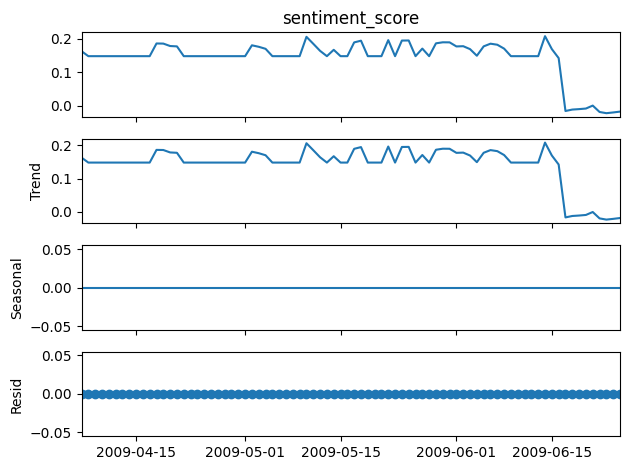

In [15]:
# Assuming merged_df is your DataFrame with 'date_only' as the index
# and 'sentiment_score' as the column with sentiment scores
average_sentiment_per_day = new_df.groupby('date_only')['sentiment_score'].mean()

# Convert the result to a DataFrame
daily_average_df = average_sentiment_per_day.reset_index()

# Set 'date_only' as the index
daily_average_df.set_index('date_only', inplace=True)

# Perform seasonal decomposition
result = seasonal_decompose(daily_average_df['sentiment_score'], model='additive', period=1)

# Plot the results
result.plot()
plt.show()

## Changing period of decomposition to identify any other related seasonality


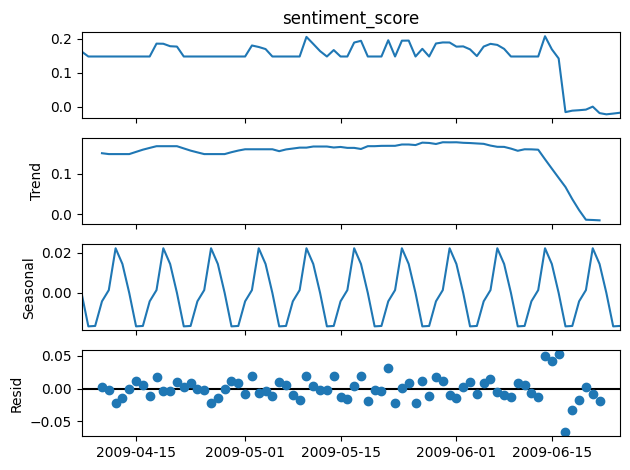

In [20]:
# Perform seasonal decomposition weekly
result = seasonal_decompose(daily_average_df['sentiment_score'], 
                            model='additive', 
                            period=7)

# Plot the results
result.plot()
plt.show()

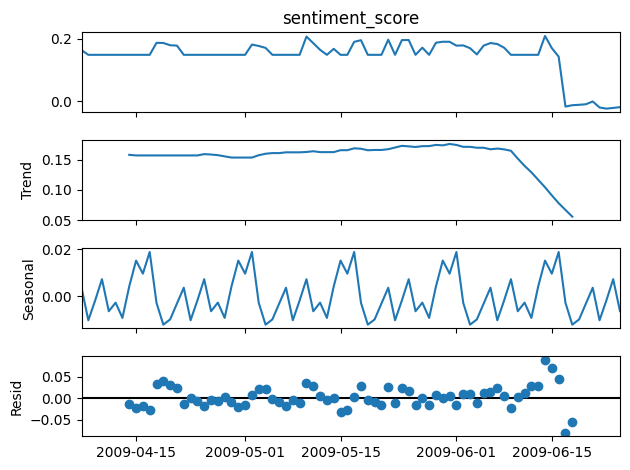

In [24]:
# Perform seasonal decomposition montly
result = seasonal_decompose(daily_average_df['sentiment_score'], 
                            model='additive', 
                            period=15)

# Plot the results
result.plot()
plt.show()

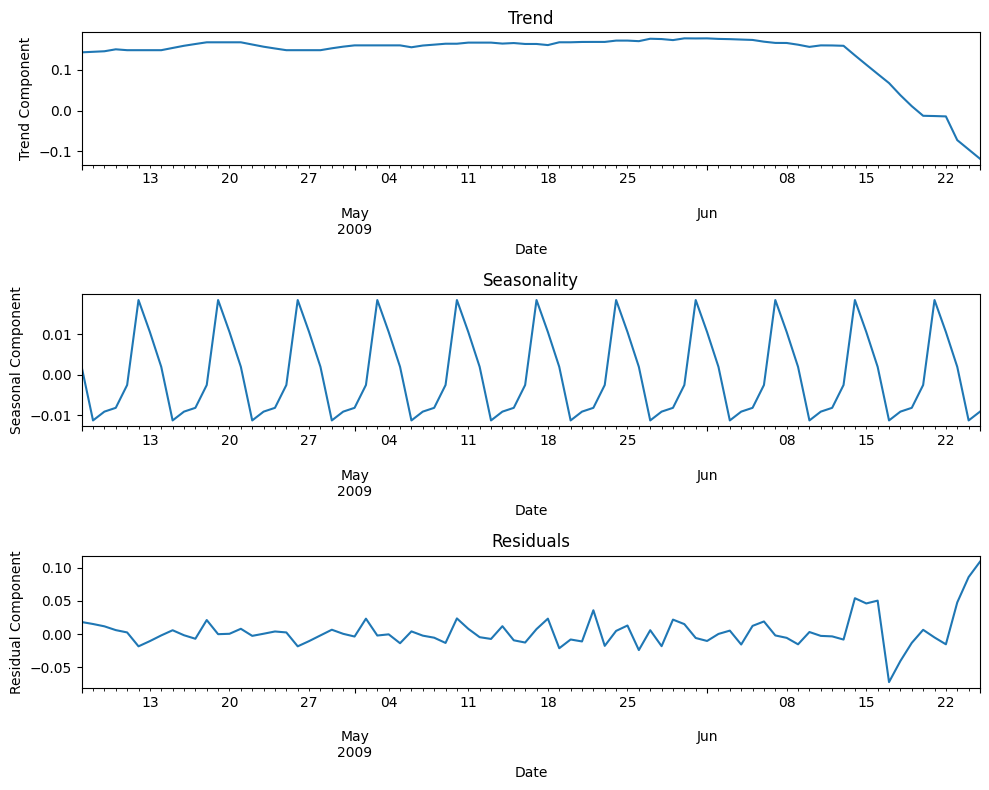

In [21]:
# Decomposing the time series.
decomposition = seasonal_decompose(daily_average_df['sentiment_score'], 
                                   model='additive', 
                                   period=7,  # Assuming no known seasonality period from the sample
                                   extrapolate_trend='freq')

# Plotting the components.
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))
decomposition.trend.plot(ax=ax1) # Trends
ax1.set_title('Trend')
ax1.set_xlabel('Date')
ax1.set_ylabel('Trend Component')

decomposition.seasonal.plot(ax=ax2) # Seasonalities
ax2.set_title('Seasonality')
ax2.set_xlabel('Date')
ax2.set_ylabel('Seasonal Component')

decomposition.resid.plot(ax=ax3) # Residuals
ax3.set_title('Residuals')
ax3.set_xlabel('Date')
ax3.set_ylabel('Residual Component')

plt.tight_layout() # sets layout
plt.show() # show the plots.

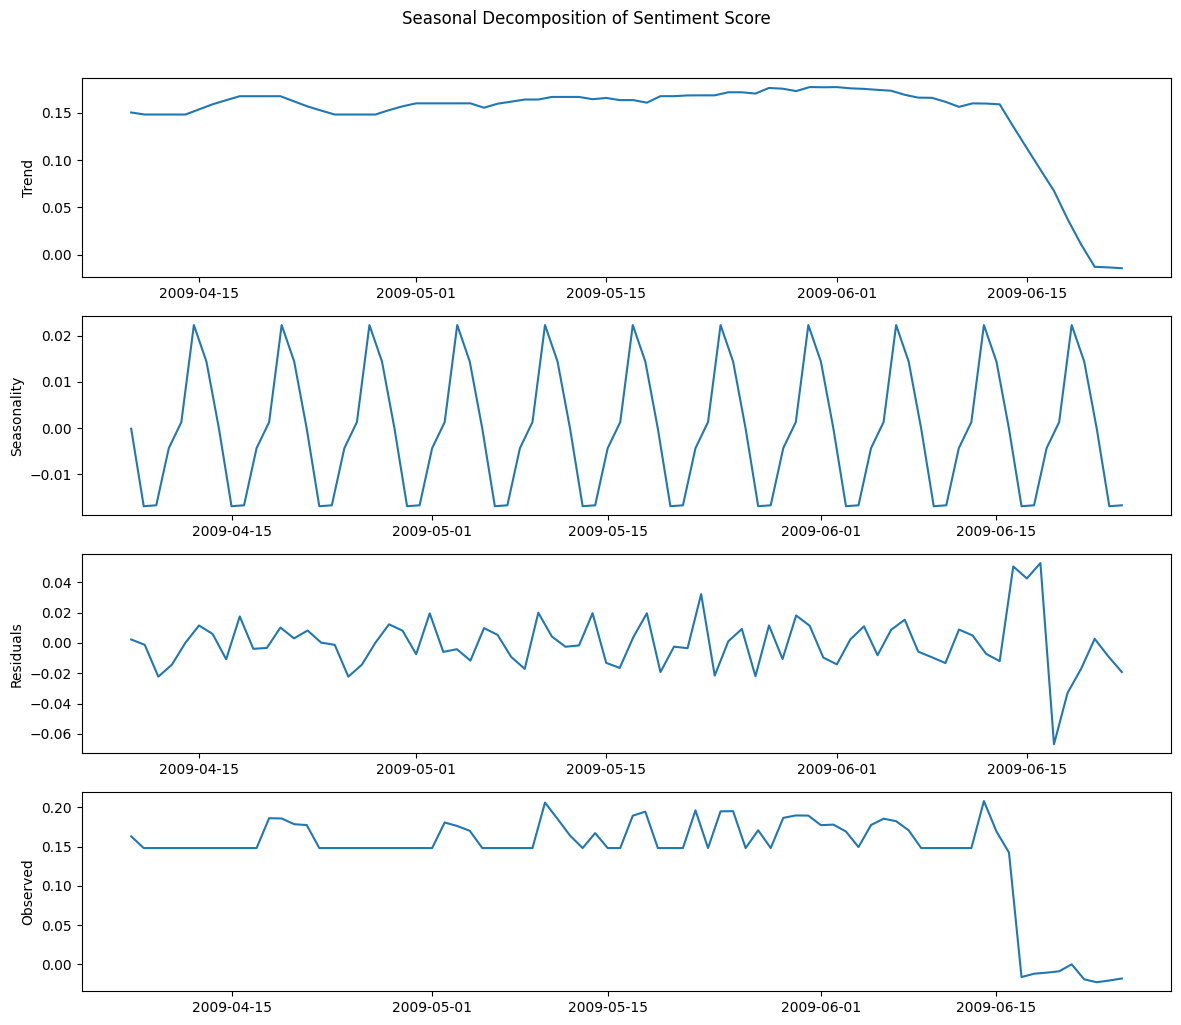

In [22]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))

ax1.set_ylabel('Trend')
ax2.set_ylabel('Seasonality')
ax3.set_ylabel('Residuals')
ax4.set_ylabel('Observed')

ax1.plot(result.trend)
ax2.plot(result.seasonal)
ax3.plot(result.resid)
ax4.plot(result.observed)

plt.suptitle('Seasonal Decomposition of Sentiment Score', y=1.02)
plt.tight_layout()
plt.show()

## Hyperparameter Tuning 

Grid search is simple but may be computationally expensive, while optimization libraries like Optuna and Ray Tune offer more sophisticated methods for finding optimal hyperparameters. Optuna is a hyperparameter optimization framework that supports optimization of any machine learning model. It is flexible and easy to use. https://optuna.org/#installation


In [18]:
import optuna
from statsmodels.tsa.arima.model import ARIMA

In [19]:
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima.model import ARIMA